# Poisson's problem

## General formulation

Here I provide the "Hello, world!" of FEM. The Poisson's problem subject to Dirichlet boundary conditions is stated as:

Find $u \in \mathbb{C}^2$ such that:

\begin{equation}
\left\{
\begin{aligned}
- &\Delta u = f(x), \quad \forall x \in (\Omega \subset \mathbb{R}^n) \\
&\left. u \right|_{\partial \Omega} = g(x)
\end{aligned}
\right.
\end{equation}
where $\overline{\Omega} := \Omega \cup \partial \Omega$ denotes the closed domain, $\Omega$ is the open domain and $\partial \Omega$ is the domain's boundary (the closure). Note that $\Omega \cap \partial \Omega = \emptyset$. The solution is a scalar field such that $u: \overline{\Omega} \to \mathbb{R}$. Also, we have the "source term" that is a scalar field of the same form, $f: \Omega \to \mathbb{R}$, but this function is a given data to the (direct) problem. The $g(x)$ is a prescribed function applied to the boundary, which is also a given data to the problem.

P.S.: I will not discuss the ill problems formulation, neither others mathematical requirements to assert the well-posedness of the problem.

## 1D simplification

In some scenarios, the mathematical modeling approach can be simplified to the 1D case, which is written as follows:

Find $u \in \mathbb{C}^2$ such that:

\begin{equation}
\left\{
\begin{aligned}
- &\frac{d^2 u}{d x^2} = f(x), \quad \forall x \in ((x_1, x_2) \subset \mathbb{R}) \\
&u(x_1) = u_1 \\
&u(x_2) = u_2
\end{aligned}
\right.
\end{equation}

where $u_1, u_2 \in \mathbb{R}$ are the prescribed boundary condition values. Such problems are known as Two-Point Boundary Value problems.

### Variational formulation and Galerkin approximation

One can find the derivation of the weak form, but I will just give its result below.

Given the space of admissible solution:

\begin{equation}
\mathcal{U} (\Omega) := \left\{ u \in H^1 (\Omega) \left| \,u(x_1) = u_1, u(x_2) = u_2 \right. \right\}
\end{equation}

and the space of suitable variations as

\begin{equation}
\mathcal{V} (\Omega) := \left\{ v \in H^1 (\Omega) \left| \,u(x_1) = u(x_2) = 0 \right. \right\}
\end{equation}

The discretization of the above spaces is performed by Galerkin approximation with Lagrangean function space $\mathbb{P}$ of order $k$ defined over $\Omega$. Thus we define here:

\begin{equation}
            \mathcal{S}_h^k(\Omega) := \left\{ \varphi_h \in \mathcal{C}(\Omega^e): \left.\varphi\right|_{\Omega^e} 
            \in \mathbb{P}_k(\Omega^e), \forall \Omega^e \in \mathcal{T}_h \right\}
\end{equation}

the space of Lagrange polynomials subject to a domain partition $\mathcal{T}_h:=\cup \Omega^e \approx \overline{\Omega}$ and $\cap \Omega^e = \emptyset$ (non-overlapping elements). Thus

\begin{equation}
    \mathcal{U}_h := \mathcal{U} \cap \mathcal{S}_h^k \quad \text{and} \quad
    \mathcal{V}_h := \mathcal{V} \cap \mathcal{S}_h^k
\end{equation}

we have the discretized spaces.

Now, we can stated out our "discretized" Variational Formulation as:

Find $u_h \in \mathcal{U}_h$ such that

\begin{equation}
a(u_h, v_h) = F(v_h), \quad \forall v_h \in \mathcal{V}_h
\end{equation}

where

\begin{align}
a(u, v) &:= \int_{\Omega} \frac{d u}{d x} \frac{d v}{d x} dx \\
F(v) &:= \int_{\Omega} f v dx
\end{align}

and the domain is $\overline{\Omega} \equiv [x_1, x_2]$.

### A practical FEniCS example

Solve this in FEniCS is very straightforward compared to classical FEM codes. The FEniCS framework provides a high-level interface which eases the pain at most.

Just for learning purpose, let the given data be setted as:

\begin{align}
&f(x) \equiv f = 1 \\
&u_1 = u_2 = 0 \\
&x_1 = 0, \quad x_2 = 1
\end{align}

With the source term as $f(x) = 1$, the exact solution can be easily obtained:

\begin{equation}
u(x) = \frac{1}{2}\left(x_1^2 - x^2\right) + \left[\frac{1}{2}(x_1 + x_2) + \frac{u_1 - u_2}{x_1 - x_2} \right] (x - x_1) + u_1
\end{equation}

So, how to solve the problem with FEniCS? We will construct the procedures stepwise.

* Importing all the libs we'll need. 

In [1]:
from fenics import *  # all the FEniCS namespace (not a recommended Python practice)
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

* Defining the domain and related mesh

In [2]:
x_left = 0.0
x_right = 1.0
numel = 15
mesh = IntervalMesh(numel, x_left, x_right)  # IntervalMesh(num_of_elements, inf_interval, sup_interval)
mesh_ref = IntervalMesh(100, x_left, x_right)

* Setting the degree of the functions in the Continuous Galerkin method and the variation space. Additionaly, we define here a space to be employed in the projection of the reference analytical solution

In [3]:
p = 1
V = FunctionSpace(mesh, "CG", p)  # "CG" stands for Continuous Galerkin, p is the degree
Vref = FunctionSpace(mesh_ref, "CG", p)

* Defining a Python function which marks the boundaries

In [4]:
def left(x, on_boundary):
    return x < 0+DOLFIN_EPS
def right(x, on_boundary):
    return x > 1-DOLFIN_EPS

* Setting the prescribed boundary values

In [5]:
u1, u2 = 0.0, 0.0
g_left = Constant(u1)
g_right = Constant(u2)

* Now we modify the spaces, as expected

In [6]:
bc_left = DirichletBC(V, g_left, left)
bc_right = DirichletBC(V, g_right, right)
dirichlet_condition = [bc_left, bc_right]

* Here we define the source function over the domain

In [7]:
f = Constant(1)

* Now comes the good part. We set up the Trial and Test functions from the admissible space

In [8]:
u_h = TrialFunction(V)
v_h = TestFunction(V)

* Then we write the bilinear form, very much like it is written in mathematical form

\begin{equation}
a(u_h, v_h) \equiv \left(\frac{d u_h}{d x}, \frac{d v_h}{d x}\right) = \int_{\Omega} \frac{d u_h}{d x} \frac{d v_h}{d x} dx
\end{equation}

In [9]:
a = inner(grad(v_h), grad(u_h))*dx

* Also we define the associated linear form

\begin{equation}
(f, v_h) = \int_{\Omega} f v_h dx
\end{equation}

In [10]:
L = f*v_h*dx

* Now we declare the solution variable, which means that `u_sol` is a function over the space $\mathcal{V}$

In [11]:
u_sol = Function(V)

* Thus we set the discretized variational problem to be solved. The problem is declared with the FEniCS function `LinearVariationalProblem`, that has as arguments the LHS, the RHS, the variable where the solution will be stored and computed and the essential boundary conditions to be considered

In [12]:
problem = LinearVariationalProblem(a, L, u_sol, dirichlet_condition)

* And we go further and solve it with no difficulties!

In [13]:
solver = LinearVariationalSolver(problem)
solver.solve()

* But we will need to check if the solution is "good enough". So we compare with the available exact solution

In [14]:
sol_exact = Expression(
    "(1. / 2.) * (pow(x_1,2.0) - pow(x[0],2.0)) + \
    ((1./2.) * (x_1 + x_2) + (u_1 - u_2) / (x_1 - x_2)) * (x[0] - x_1) + u_1", 
    degree=p+1, 
    u_1=u1, 
    u_2=u2, 
    x_1=x_left, 
    x_2=x_right
)
u_e = interpolate(sol_exact, Vref)

* Now, lets plot our results!

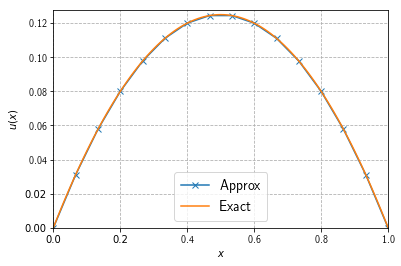

In [15]:
plot(u_sol, marker='x', label='Approx')
plot(u_e, label='Exact')
# Setting the font
plt.rc('text',usetex=True)
plt.rc('font', size=14)
# Plotting
plt.xlim(x_left, x_right)   # Limites do eixo x
plt.ylim(np.min(u_sol.vector().get_local()), 1.02*np.max(u_e.vector().get_local()))  # Limites do eixo y
plt.grid(True, linestyle='--')  # Ativa o grid do grafico
plt.xlabel(r'$x$')  # Legenda do eixo x
plt.ylabel(r'$u(x)$')   # Legenda do eixo y
plt.legend(loc='best',borderpad=0.5)    # Ativa legenda no grafico e diz para se posicionar na melhor localizacao detectada
plt.show()  # Exibe o grafico em tela